# scRNA data analysis: Normalization and Variable Feature selection

In [2]:
#####################
# Library Loading
#####################
library(Seurat)
library(cowplot)
library(ggplot2)
library(tidyverse)
library(Matrix)

In [3]:
PLOTLY_Pallett = c('#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf')
GroupID_Order_List = c("CCR6neg", "CCR6low", "CCR6int", "CCR6high")
GroupID_Color_List = c("CCR6neg"="#FFA500", "CCR6low"="#0456f8", "CCR6int"="#1D8F06", "CCR6high"="#e51134")

In [4]:
######################
# LOAD DATA
######################
alldata <- readRDS("./Result/CCR6_Project_00_filt_QC.rds")

## Normalize expression

#### Now that we have performed our initial Cell level QC, and removed potential outliers, we can go ahead and normalize the data. By default, Seurat implements a global-scaling normalization method “LogNormalize” that normalizes the gene expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result.

In [5]:
alldata <- NormalizeData(object = alldata, normalization.method = "LogNormalize", scale.factor = 10000)

In [6]:
paste("Number of Cells across all subset after normalization: ", ncol(alldata))
paste("Number of Gene across all subset after normalization", nrow(alldata))

[1] "Number of Cells across all subset after normalization:  9301"

[1] "Number of Gene across all subset after normalization 33538"

### select top 20 gene

In [7]:
gene_counts_DF = alldata@assays$RNA@data
total_gene_count = Matrix::rowSums(gene_counts_DF)
#head(total_gene_count)
total_gene_count_DF = as.data.frame(total_gene_count) %>% rownames_to_column("Name")
colnames(total_gene_count_DF)[2] <- "Count"
#head(total_gene_count_DF)
top_gene_count = total_gene_count_DF  %>% filter(str_detect(Name, "^RP[SL]|^MT-") ==  FALSE) %>% arrange(desc(Count)) %>% head(20)
head(top_gene_count)
####################
#FEATURE ORDER/COLOR
####################
Feature_Order_List = unique(top_gene_count$Name)
Feature_List_Size = length(Feature_Order_List)
Feature_Label_Dict = Feature_Order_List
names(Feature_Label_Dict) = Feature_Order_List
Feature_Order_Factor = factor(Feature_Order_List, levels=Feature_Order_List)
if(Feature_List_Size > 10){
    Feature_Color_List = colorRampPalette(PLOTLY_Pallett)(Feature_List_Size)
}else{
    Feature_Color_List = PLOTLY_Pallett[1:Feature_List_Size]
}
Feature_Color_Dict = Feature_Color_List
names(Feature_Color_Dict) = Feature_Order_List

Name,Count
EEF1A1,51732.94
MALAT1,47275.74
TPT1,42842.65
B2M,39236.14
FTH1,38717.11
FAU,34547.65


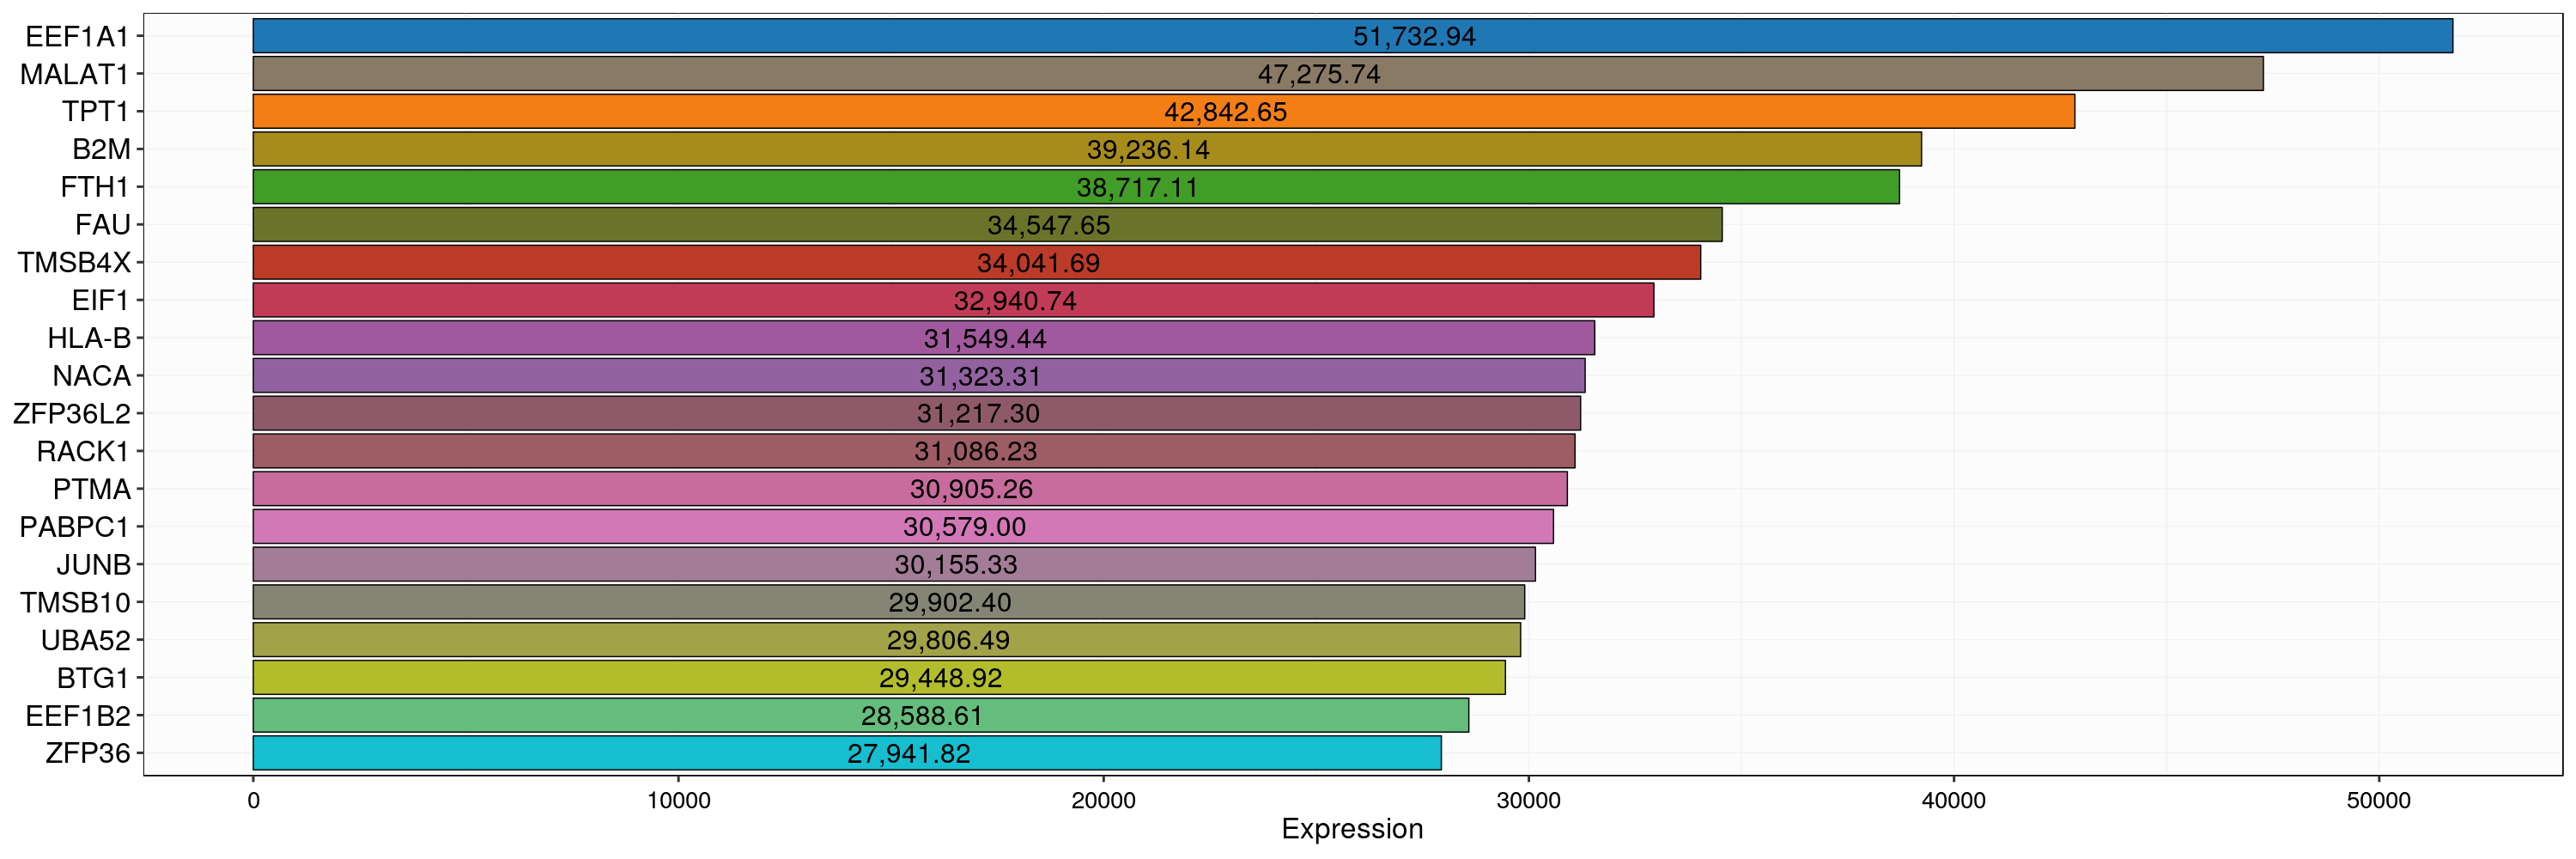

In [10]:
options(repr.plot.width=15, repr.plot.height=5, repr.plot.res = 200)
ggplot(data= top_gene_count,
    aes(x=reorder(Name, Count), y=Count, fill=Name)) +
    geom_bar(stat = "identity", color="black", size = 0.25, na.rm = TRUE) +
    geom_text(aes(label = scales::comma(Count)), position = position_stack(vjust = 0.5), size=4, hjust = 0, color="black") +
scale_fill_manual(breaks = Feature_Order_List, labels=Feature_Label_Dict, limits=Feature_Order_List, values=Feature_Color_Dict, guide = guide_legend(reverse = TRUE),name = NULL ) +
    labs(title = NULL, subtitle = NULL, caption = NULL, tag = NULL, x=NULL, y="Expression") +
    theme_grey() +
    theme(
        text=element_text(family="sans"),
        plot.title = element_text(size=14, color = "black", face = "plain", hjust = 0),
        plot.subtitle = element_text(size=12, color = "black", face = "plain", hjust = 0 ),
        plot.caption = element_text(size=10, color = "black", face = "plain"),
        #X-AXIS
        axis.title.x = element_text(size=12, color = "black", face = "plain", vjust=1),
        axis.text.x = element_text(size=10, color = "black", face = "plain", angle=0, vjust=0.5),
        #Y-AXIS
        axis.title.y = element_text(size=12, color = "black", face = "plain", vjust=1),
        axis.text.y = element_text(size=12, color = "black", face = "plain", vjust=0.5),
        #Panel
        panel.grid.major = element_line(color = "grey95", size = 0.25), 
        panel.grid.minor = element_line(color = "grey95", size = 0.25),
        panel.background = element_rect(color = "black", size = 0.25, fill = "grey99"),
        panel.border = element_rect(color = "black", size = 0.25, fill = NA),
        #Strip
        strip.text = element_text(size=14, face="plain", color = "black"),
        strip.text.x = element_text(size=12, face="plain", color = "black"),
        strip.text.y = element_text(size=10, face="plain", color = "black"),
        strip.background = element_rect(color = "black", size = 0.25, fill = "grey95"),
        #LEGEND
        legend.position="none",
        legend.title = element_blank(),
        legend.key=element_blank(),
        legend.text = element_text(size=8, face="plain", color = "black", angle=0, vjust=0.5),
        legend.background = element_blank(),

    ) + 
coord_flip()

### VARIABLE Feature Selection

#### Seurat calculates highly variable genes and focuses on these for downstream analysis. FindVariableGenes calculates the average expression and dispersion for each gene, places these genes into bins, and then calculates a z-score for dispersion within each bin. This helps control for the relationship between variability and average expression.

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”


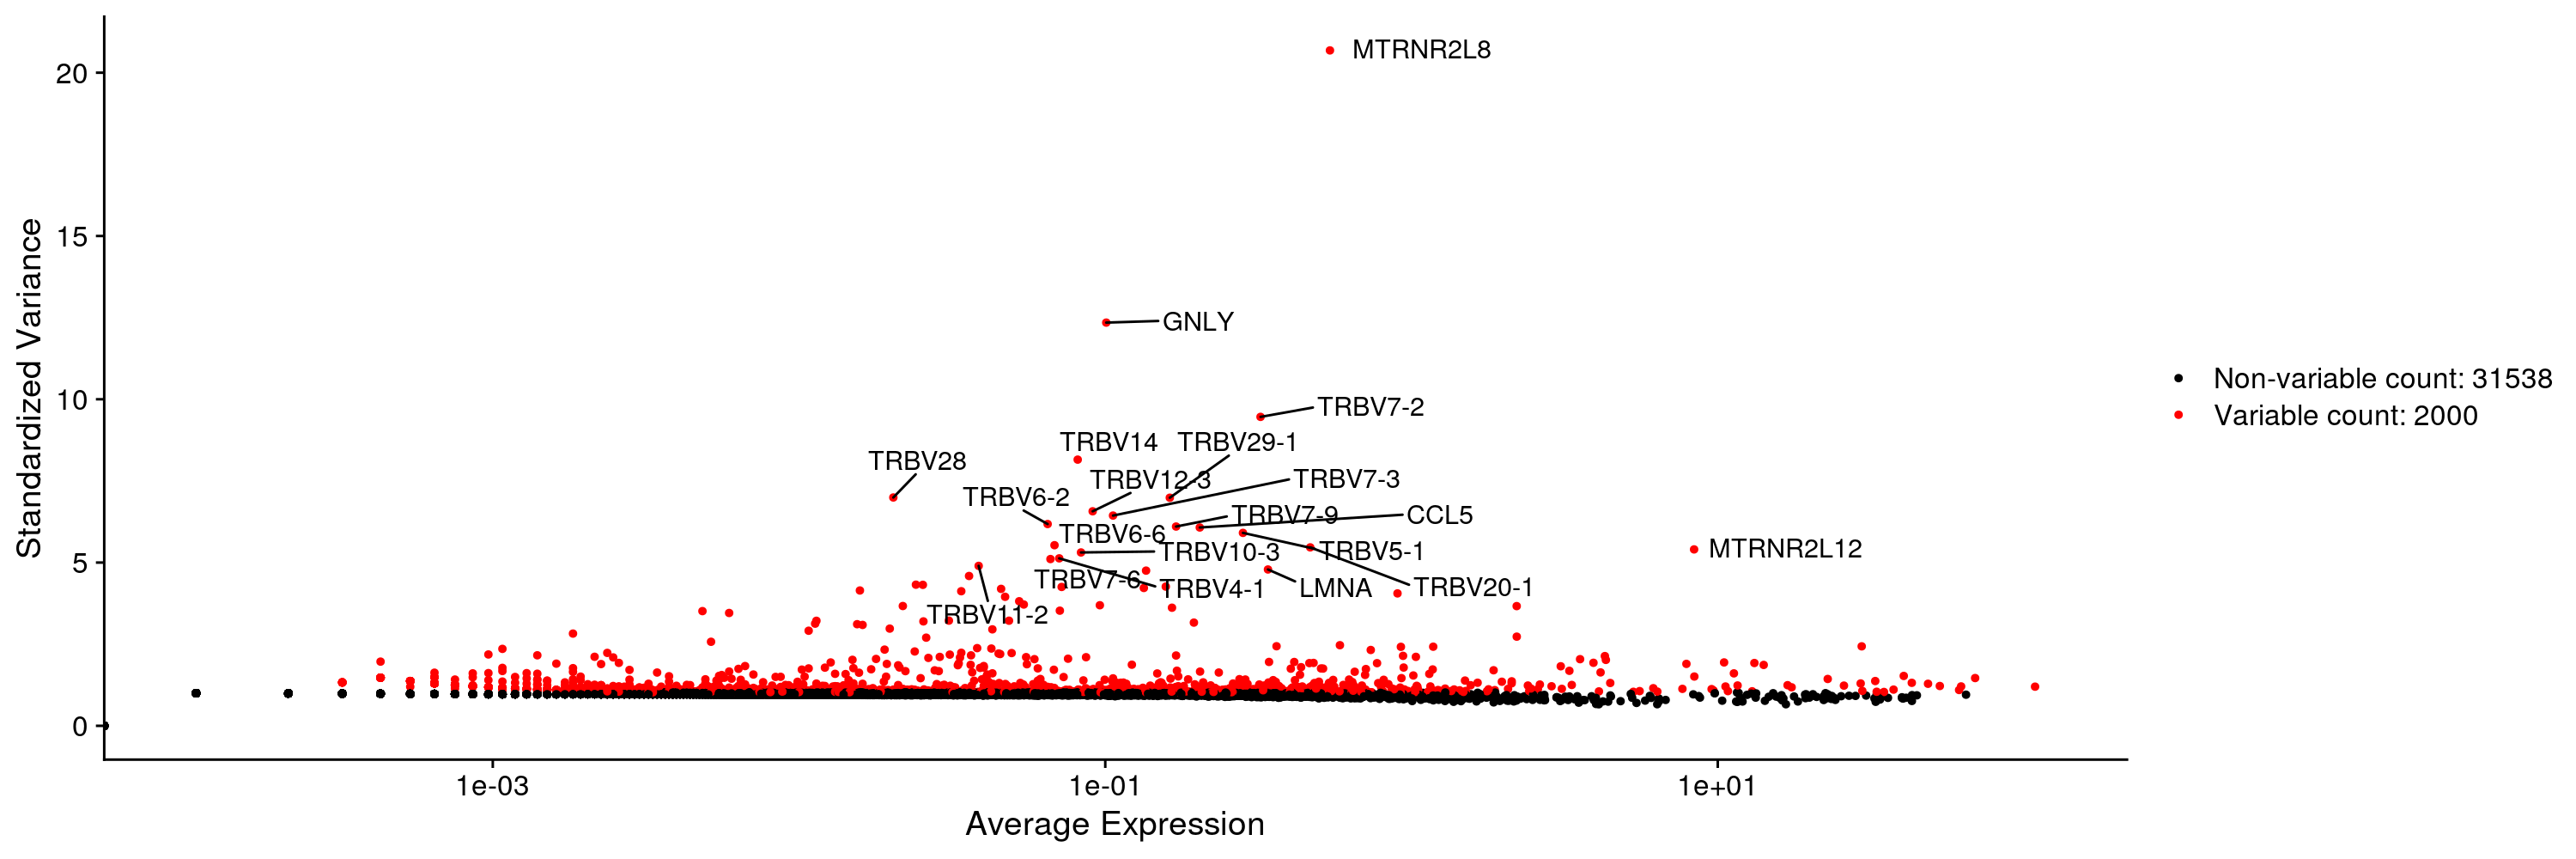

In [11]:
options(repr.plot.width=15, repr.plot.height=5, repr.plot.res = 200)
#check to see are you applying raw count or filtered one
suppressWarnings(suppressMessages(alldata <- FindVariableFeatures(alldata, mean.function = ExpMean, dispersion.function = LogVMR, 
    x.low.cutoff = 0.0125, x.high.cutoff = 3, y.cutoff = 0.5,verbose = FALSE,assay = "RNA")))
top20 <- head(VariableFeatures(alldata), 20)

LabelPoints(plot = VariableFeaturePlot(alldata), points = top20, repel = TRUE)

## variable feature

In [12]:
gene_counts_DF = alldata@assays$RNA@data
total_gene_count = Matrix::rowSums(gene_counts_DF)
#head(total_gene_count)
total_gene_count_DF = as.data.frame(total_gene_count) %>% rownames_to_column("Name")
colnames(total_gene_count_DF)[2] <- "Count"
#head(total_gene_count_DF)
top_gene_count = total_gene_count_DF  %>%  filter(Name %in% top20) %>% arrange(desc(Count))
#head(top_gene_count)

In [13]:
####################
#FEATURE ORDER/COLOR
####################
Feature_Order_List = unique(top_gene_count$Name)
Feature_List_Size = length(Feature_Order_List)
Feature_Label_Dict = Feature_Order_List
names(Feature_Label_Dict) = Feature_Order_List
Feature_Order_Factor = factor(Feature_Order_List, levels=Feature_Order_List)
if(Feature_List_Size > 10){
    Feature_Color_List = colorRampPalette(PLOTLY_Pallett)(Feature_List_Size)
}else{
    Feature_Color_List = FEATURE_PALLETT[1:Feature_List_Size]
}
Feature_Color_Dict = Feature_Color_List
names(Feature_Color_Dict) = Feature_Order_List

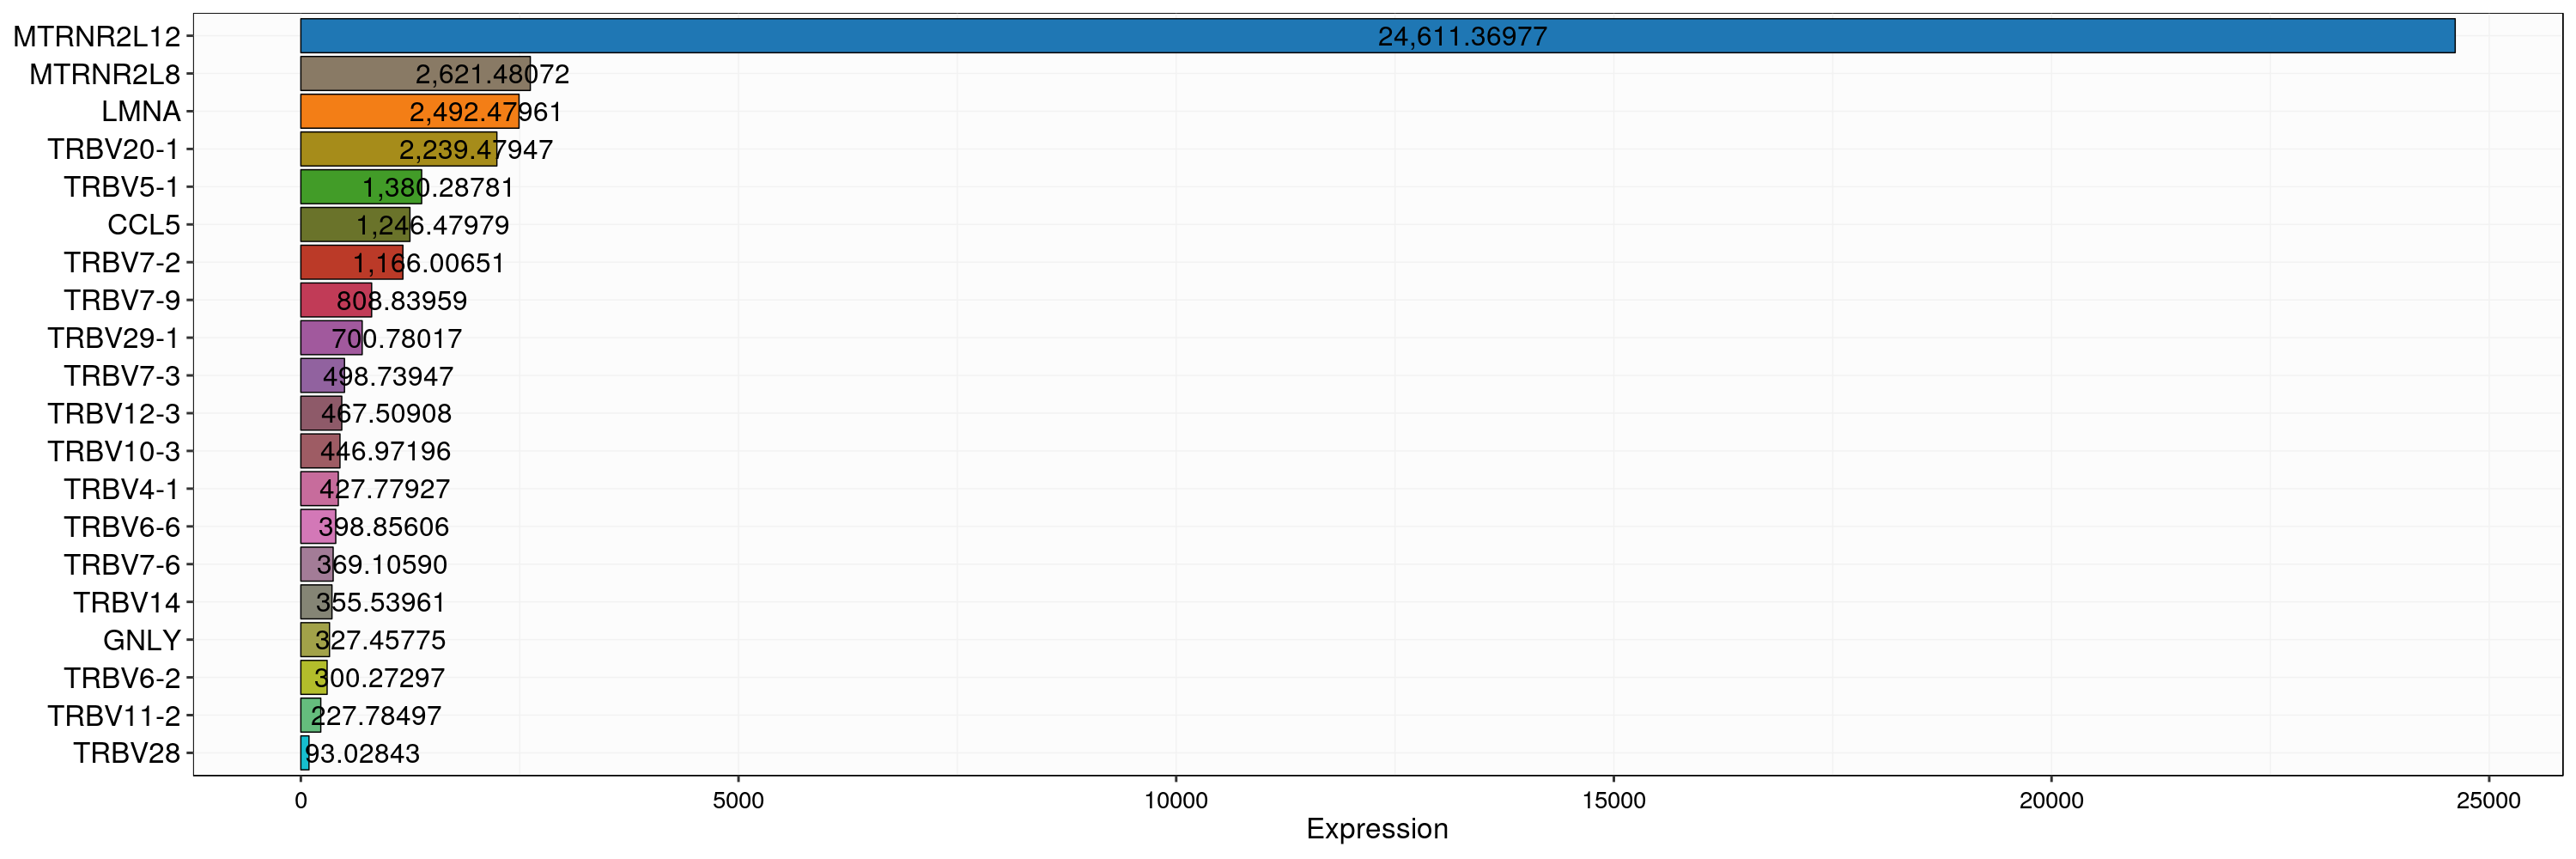

In [14]:
options(repr.plot.width=15, repr.plot.height=5, repr.plot.res = 200)
ggplot(data= top_gene_count,
    aes(x=reorder(Name, Count), y=Count, fill=Name)) +
    geom_bar(stat = "identity", color="black", size = 0.25, na.rm = TRUE) +
    geom_text(aes(label = scales::comma(Count)), position = position_stack(vjust = 0.5), size=4, hjust = 0, color="black") +
scale_fill_manual(breaks = Feature_Order_List, labels=Feature_Label_Dict, limits=Feature_Order_List, values=Feature_Color_Dict, guide = guide_legend(reverse = TRUE),name = NULL ) +
    labs(title = NULL, subtitle = NULL, caption = NULL, tag = NULL, x=NULL, y="Expression") +
    theme_grey() +
    theme(
        text=element_text(family="sans"),
        plot.title = element_text(size=14, color = "black", face = "plain", hjust = 0),
        plot.subtitle = element_text(size=12, color = "black", face = "plain", hjust = 0 ),
        plot.caption = element_text(size=10, color = "black", face = "plain"),
        #X-AXIS
        axis.title.x = element_text(size=12, color = "black", face = "plain", vjust=1),
        axis.text.x = element_text(size=10, color = "black", face = "plain", angle=0, vjust=0.5),
        #Y-AXIS
        axis.title.y = element_text(size=12, color = "black", face = "plain", vjust=1),
        axis.text.y = element_text(size=12, color = "black", face = "plain", vjust=0.5),
        #Panel
        panel.grid.major = element_line(color = "grey95", size = 0.25), 
        panel.grid.minor = element_line(color = "grey95", size = 0.25),
        panel.background = element_rect(color = "black", size = 0.25, fill = "grey99"),
        panel.border = element_rect(color = "black", size = 0.25, fill = NA),
        #Strip
        strip.text = element_text(size=14, face="plain", color = "black"),
        strip.text.x = element_text(size=12, face="plain", color = "black"),
        strip.text.y = element_text(size=10, face="plain", color = "black"),
        strip.background = element_rect(color = "black", size = 0.25, fill = "grey95"),
        #LEGEND
        legend.position="none",
        legend.title = element_blank(),
        legend.key=element_blank(),
        legend.text = element_text(size=8, face="plain", color = "black", angle=0, vjust=0.5),
        legend.background = element_blank(),

    ) + 
coord_flip()

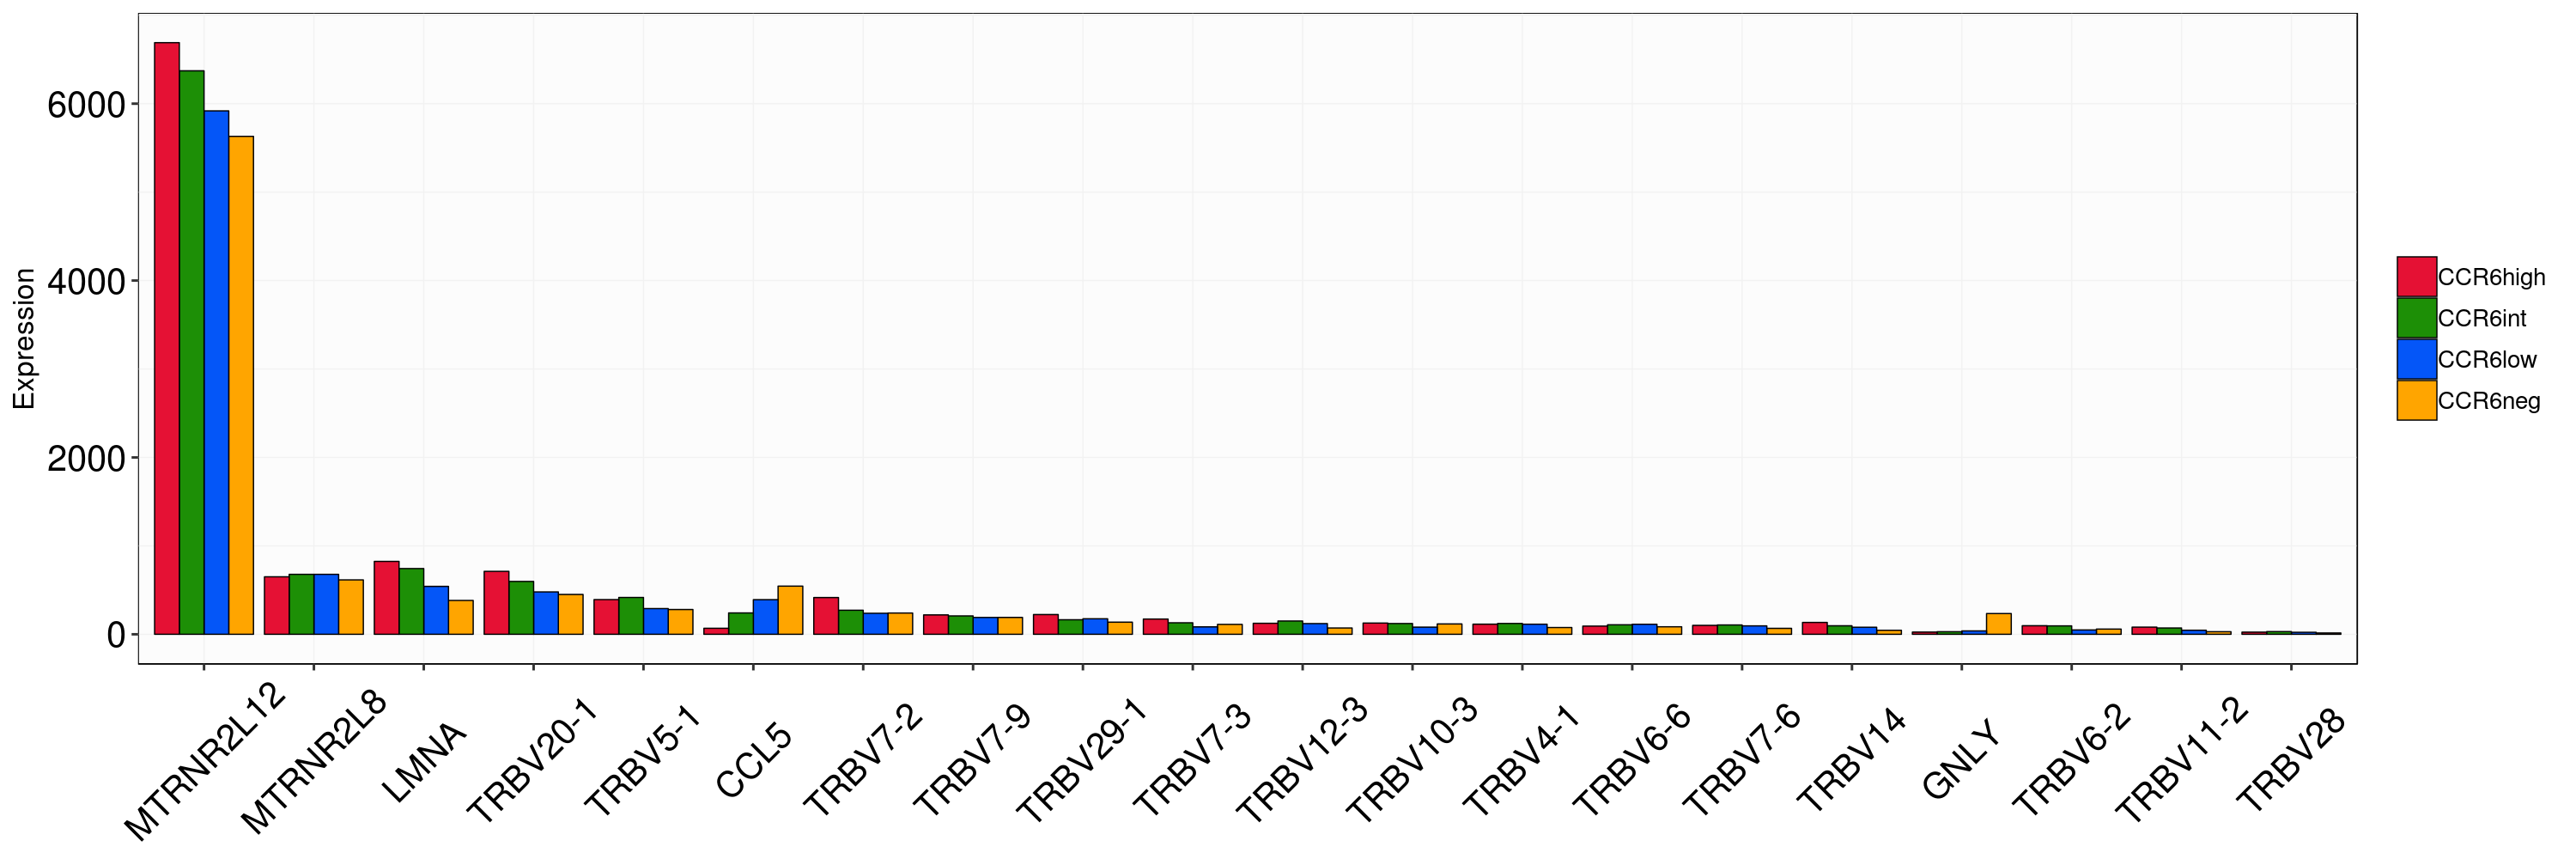

In [15]:
options(repr.plot.width=15, repr.plot.height=5, repr.plot.res = 200)
Gene_count_table = as.data.frame(gene_counts_DF[top_gene_count$Name,]) %>% rownames_to_column("Gene_name") %>% gather("UMI", "count", -Gene_name)
#head(Gene_count_table)
#
gene_count_subset_DF = Gene_count_table %>% separate(UMI, into=c("subset", "UMI"), sep = "_") 
#head(gene_count_subset_DF)
#
subset_DF = gene_count_subset_DF %>%
    # select required column
    select(c(Gene_name, subset, count))
#head(subset_DF)
#
subset_abundance_DF = subset_DF %>%
    group_by(subset, Gene_name) %>%
    summarise(Total=sum(count))
#head(subset_abundance_DF)
#
ggplot(data= subset_abundance_DF,
    aes(x=reorder(Gene_name, -Total), y=Total, fill=subset)) +
    geom_bar(position="dodge", stat = "identity", color="black", size = 0.25, na.rm = TRUE) +
    #geom_text(aes(label = scales::comma(Total)), position = position_stack(vjust = 0.5), size=4, hjust = 0, color="black") +
#scale_fill_manual(breaks = Feature_Order_List, labels=Feature_Label_Dict, limits=Feature_Order_List, values=Feature_Color_Dict, guide = guide_legend(reverse = TRUE),name = NULL ) +
scale_fill_manual(labels=Feature_Label_Dict, values=GroupID_Color_List) + 
    labs(title = NULL, subtitle = NULL, caption = NULL, tag = NULL, x=NULL, y="Expression") +
    theme_grey() +
    theme(
        text=element_text(family="sans"),
        plot.title = element_text(size=14, color = "black", face = "plain", hjust = 0),
        plot.subtitle = element_text(size=12, color = "black", face = "plain", hjust = 0 ),
        plot.caption = element_text(size=10, color = "black", face = "plain"),
        #X-AXIS
        axis.title.x = element_text(size=12, color = "black", face = "plain", vjust=1),
        axis.text.x = element_text(size=15, color = "black", face = "plain", angle=45, vjust=0.5),
        #Y-AXIS
        axis.title.y = element_text(size=12, color = "black", face = "plain", vjust=1),
        axis.text.y = element_text(size=15, color = "black", face = "plain", vjust=0.5),
        #Panel
        panel.grid.major = element_line(color = "grey95", size = 0.25), 
        panel.grid.minor = element_line(color = "grey95", size = 0.25),
        panel.background = element_rect(color = "black", size = 0.25, fill = "grey99"),
        panel.border = element_rect(color = "black", size = 0.25, fill = NA),
        #Strip
        strip.text = element_text(size=14, face="plain", color = "black"),
        strip.text.x = element_text(size=12, face="plain", color = "black"),
        strip.text.y = element_text(size=10, face="plain", color = "black"),
        strip.background = element_rect(color = "black", size = 0.25, fill = "grey95"),
        #LEGEND
        #legend.position="none",
        legend.title = element_blank(),
        legend.key=element_blank(),
        legend.text = element_text(size=10, face="plain", color = "black", angle=0, vjust=0.5),
        legend.background = element_blank(),

    )

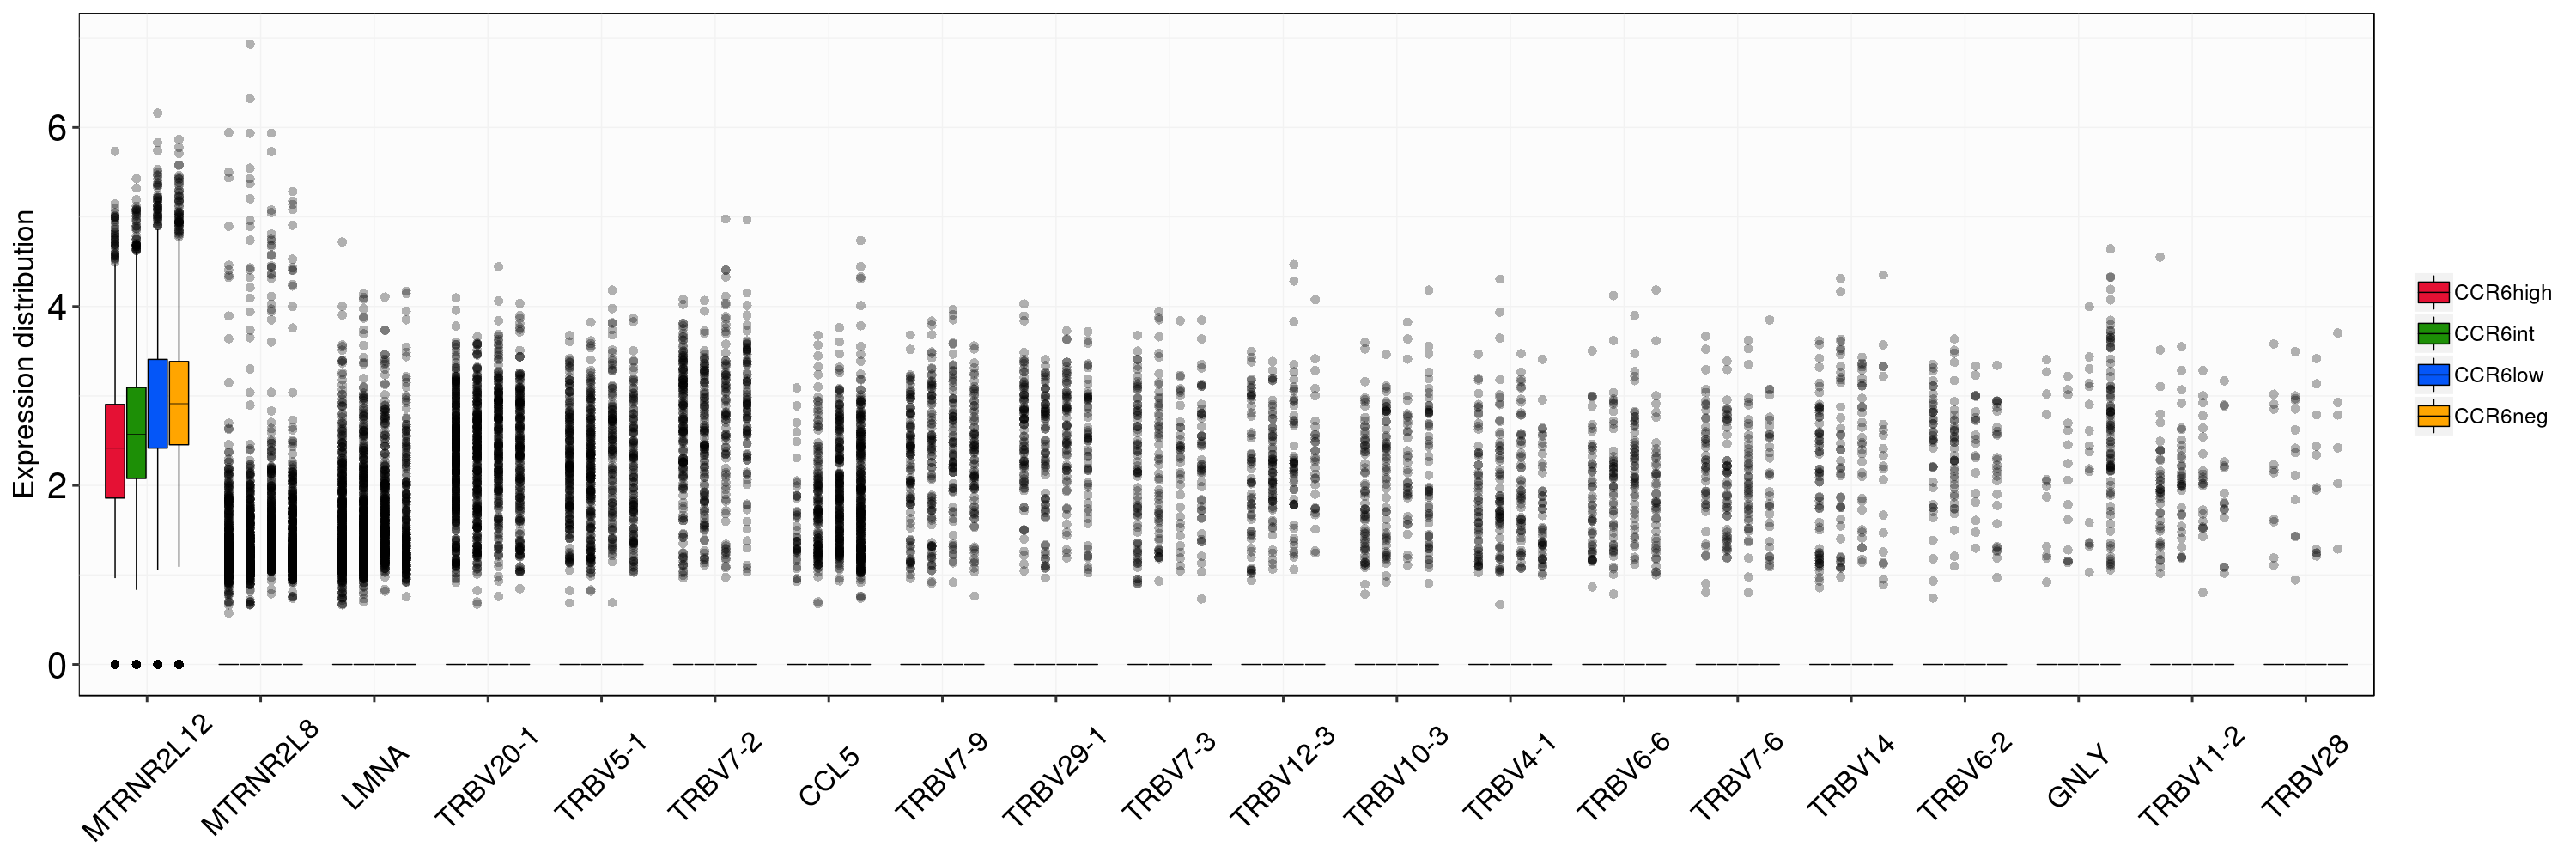

In [16]:
options(repr.plot.width=15, repr.plot.height=5, repr.plot.res = 200)
subset_abundance_DF = subset_DF %>%
    group_by(subset, Gene_name) %>%
    mutate(Total=sum(count))
#head(subset_abundance_DF)

ggplot(data= subset_abundance_DF,
    aes(x=reorder(Gene_name, -Total), y=count, fill=subset)) +
    
    geom_boxplot(stat = "boxplot", position = "dodge2", aes(fill=subset), outlier.shape=16, outlier.alpha=0.3, na.rm = TRUE, size = 0.25, show.legend=TRUE, color="black", fatten = 0.5) +
    scale_fill_manual(labels=Feature_Label_Dict, values=GroupID_Color_List) +  
    labs(title = NULL, subtitle = NULL, caption = NULL, tag = NULL, x=NULL, y="Expression distribution") +
    theme_grey() +
    theme(
        text=element_text(family="sans"),
        plot.title = element_text(size=14, color = "black", face = "plain", hjust = 0),
        plot.subtitle = element_text(size=12, color = "black", face = "plain", hjust = 0 ),
        plot.caption = element_text(size=10, color = "black", face = "plain"),
        #X-AXIS
        axis.title.x = element_text(size=12, color = "black", face = "plain", vjust=1),
        axis.text.x = element_text(size=12, color = "black", face = "plain", angle=45, vjust=0.5),
        #Y-AXIS
        axis.title.y = element_text(size=12, color = "black", face = "plain", vjust=1),
        axis.text.y = element_text(size=15, color = "black", face = "plain", vjust=0.5),
        #Panel
        panel.grid.major = element_line(color = "grey95", size = 0.25), 
        panel.grid.minor = element_line(color = "grey95", size = 0.25),
        panel.background = element_rect(color = "black", size = 0.25, fill = "grey99"),
        panel.border = element_rect(color = "black", size = 0.25, fill = NA),
        #Strip
        strip.text = element_text(size=14, face="plain", color = "black"),
        strip.text.x = element_text(size=12, face="plain", color = "black"),
        strip.text.y = element_text(size=10, face="plain", color = "black"),
        strip.background = element_rect(color = "black", size = 0.25, fill = "grey95"),
        #LEGEND
        #legend.position="none",
        legend.title = element_blank(),
        #legend.key=element_blank(),
        #legend.text = element_text(size=10, face="plain", color = "black", angle=0, vjust=0.5),
        legend.background = element_blank(),

    )

## scale gene expression

#### The single cell dataset likely contains ‘uninteresting’ sources of variation. This could include not only technical noise, but batch effects, or even biological sources of variation (cell cycle stage).
#### As suggested in Buettner et al, NBT, 2015, regressing these signals out of the analysis can improve downstream dimensionality reduction and clustering. To mitigate the effect of these signals, Seurat constructs linear models to predict gene expression based on user-defined variables.

#### Scales and centers features in the dataset. If variables are provided in vars.to.regress, they are individually regressed against each feautre, and the resulting residuals are then scaled and centered.

#### we center the expression for each feautre by subtracting the average expression for that feautre

In [17]:
alldata <- ScaleData(alldata, features = alldata@assays$RNA@var.features, vars.to.regress = c("percent_mito", "percent_ribo"), assay = "RNA")

Regressing out percent_mito, percent_ribo

Centering and scaling data matrix



## top 20 gene after scaling

In [18]:
gene_counts_DF = alldata@assays$RNA@scale.data
total_gene_count = Matrix::rowSums(gene_counts_DF)
#head(total_gene_count)
total_gene_count_DF = as.data.frame(total_gene_count) %>% rownames_to_column("Name")
colnames(total_gene_count_DF)[2] <- "Count"
#head(total_gene_count_DF)
top_gene_count = total_gene_count_DF  %>% filter(str_detect(Name, "^RP[SL]|^MT-") ==  FALSE) %>% arrange(desc(Count)) %>% head(20)
#head(top_gene_count)
####################
#FEATURE ORDER/COLOR
####################
Feature_Order_List = unique(top_gene_count$Name)
Feature_List_Size = length(Feature_Order_List)
Feature_Label_Dict = Feature_Order_List
names(Feature_Label_Dict) = Feature_Order_List
Feature_Order_Factor = factor(Feature_Order_List, levels=Feature_Order_List)
if(Feature_List_Size > 10){
    Feature_Color_List = colorRampPalette(PLOTLY_Pallett)(Feature_List_Size)
}else{
    Feature_Color_List = FEATURE_PALLETT[1:Feature_List_Size]
}
Feature_Color_Dict = Feature_Color_List
names(Feature_Color_Dict) = Feature_Order_List

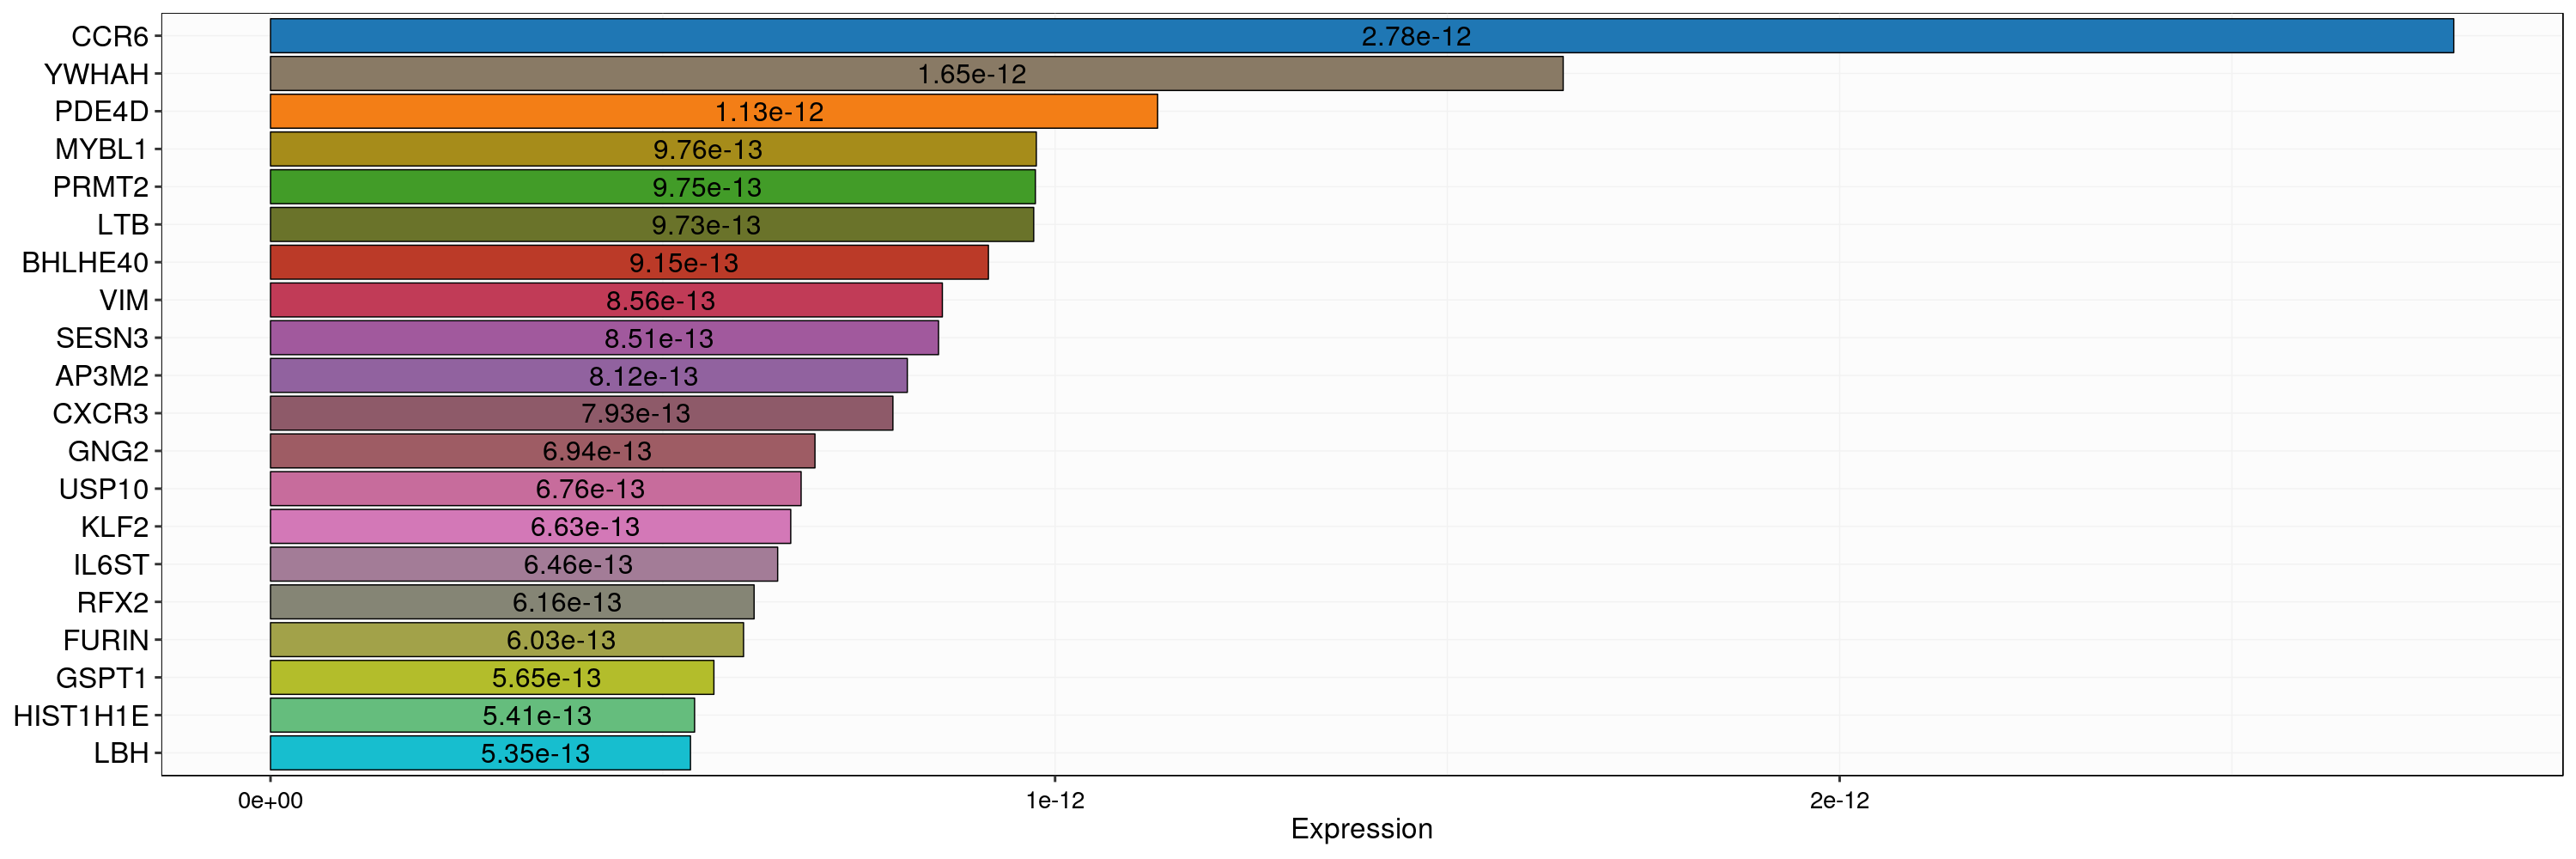

In [20]:
options(repr.plot.width=15, repr.plot.height=5, repr.plot.res = 200)
ggplot(data= top_gene_count,
    aes(x=reorder(Name, Count), y=Count, fill=Name)) +
    geom_bar(stat = "identity", color="black", size = 0.25, na.rm = TRUE) +
    geom_text(aes(label = formatC(Count, format = "e", digits = 2)), position = position_stack(vjust = 0.5), size=4, hjust = 0, color="black") +
scale_fill_manual(breaks = Feature_Order_List, labels=Feature_Label_Dict, limits=Feature_Order_List, values=Feature_Color_Dict, guide = guide_legend(reverse = TRUE),name = NULL ) +
    labs(title = NULL, subtitle = NULL, caption = NULL, tag = NULL, x=NULL, y="Expression") +
    theme_grey() +
    theme(
        text=element_text(family="sans"),
        plot.title = element_text(size=14, color = "black", face = "plain", hjust = 0),
        plot.subtitle = element_text(size=12, color = "black", face = "plain", hjust = 0 ),
        plot.caption = element_text(size=10, color = "black", face = "plain"),
        #X-AXIS
        axis.title.x = element_text(size=12, color = "black", face = "plain", vjust=1),
        axis.text.x = element_text(size=10, color = "black", face = "plain", angle=0, vjust=0.5),
        #Y-AXIS
        axis.title.y = element_text(size=12, color = "black", face = "plain", vjust=1),
        axis.text.y = element_text(size=12, color = "black", face = "plain", vjust=0.5),
        #Panel
        panel.grid.major = element_line(color = "grey95", size = 0.25), 
        panel.grid.minor = element_line(color = "grey95", size = 0.25),
        panel.background = element_rect(color = "black", size = 0.25, fill = "grey99"),
        panel.border = element_rect(color = "black", size = 0.25, fill = NA),
        #Strip
        strip.text = element_text(size=14, face="plain", color = "black"),
        strip.text.x = element_text(size=12, face="plain", color = "black"),
        strip.text.y = element_text(size=10, face="plain", color = "black"),
        strip.background = element_rect(color = "black", size = 0.25, fill = "grey95"),
        #LEGEND
        legend.position="none",
        legend.title = element_blank(),
        legend.key=element_blank(),
        legend.text = element_text(size=8, face="plain", color = "black", angle=0, vjust=0.5),
        legend.background = element_blank(),

    ) + 
coord_flip()

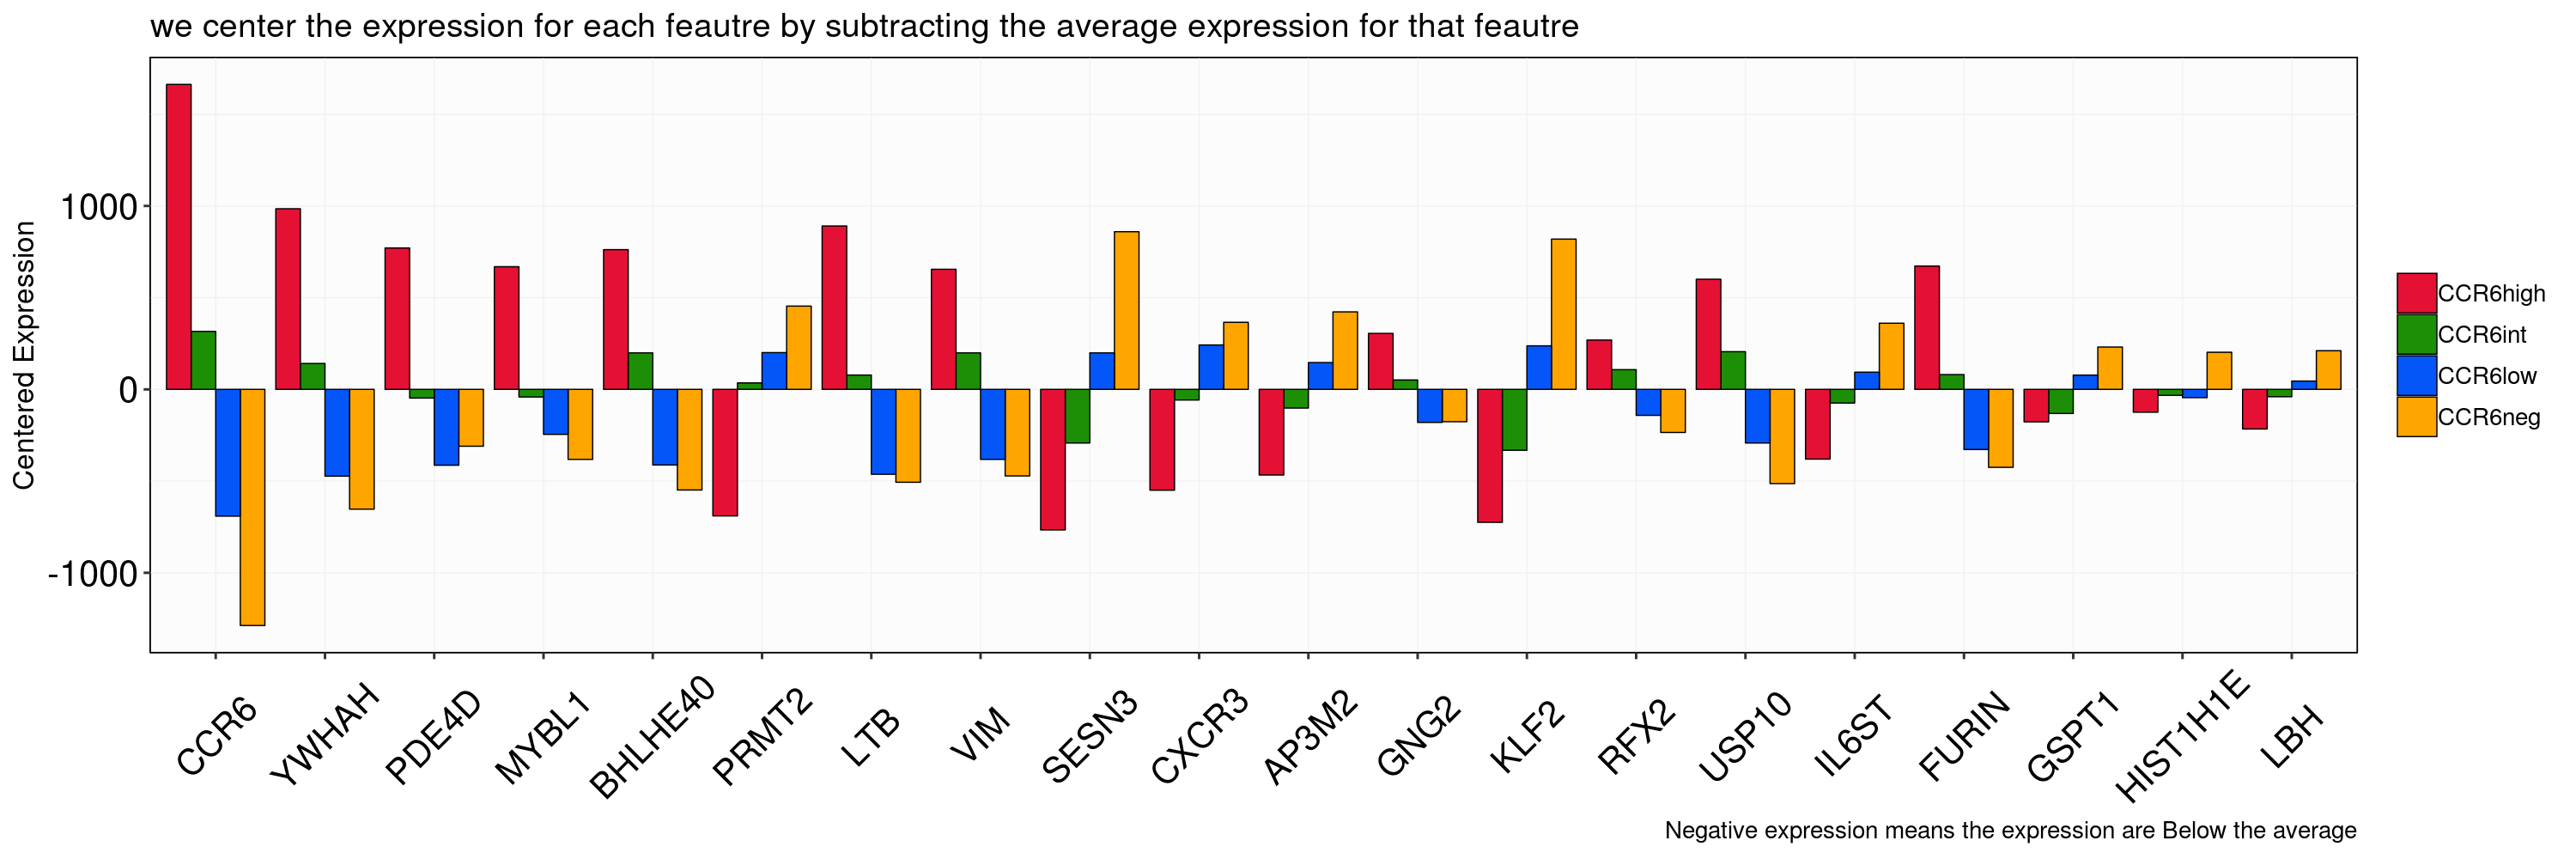

In [21]:
options(repr.plot.width=15, repr.plot.height=5, repr.plot.res = 200)
Gene_count_table = as.data.frame(gene_counts_DF[top_gene_count$Name,]) %>% rownames_to_column("Gene_name") %>% gather("UMI", "count", -Gene_name)
#head(Gene_count_table)
#
gene_count_subset_DF = Gene_count_table %>% separate(UMI, into=c("subset", "UMI"), sep = "_") 
#head(gene_count_subset_DF)
#
subset_DF = gene_count_subset_DF %>%
    # select required column
    select(c(Gene_name, subset, count))
#head(subset_DF)
#
subset_abundance_DF = subset_DF %>%
    group_by(subset, Gene_name) %>%
    summarise(Total=sum(count))
#head(subset_abundance_DF)
#
ggplot(data= subset_abundance_DF,
    aes(x=reorder(Gene_name, -Total), y=Total, fill=subset)) +
    geom_bar(position="dodge", stat = "identity", color="black", size = 0.25, na.rm = TRUE) +
    #geom_text(aes(label = scales::comma(Total)), position = position_stack(vjust = 0.5), size=4, hjust = 0, color="black") +
#scale_fill_manual(breaks = Feature_Order_List, labels=Feature_Label_Dict, limits=Feature_Order_List, values=Feature_Color_Dict, guide = guide_legend(reverse = TRUE),name = NULL ) +
scale_fill_manual(labels=Feature_Label_Dict, values=GroupID_Color_List) + 
    labs(title = "we center the expression for each feautre by subtracting the average expression for that feautre", subtitle = NULL, caption = "Negative expression means the expression are Below the average", tag = NULL, x=NULL, y="Centered Expression") +
    theme_grey() +
    theme(
        text=element_text(family="sans"),
        plot.title = element_text(size=14, color = "black", face = "plain", hjust = 0),
        plot.subtitle = element_text(size=12, color = "black", face = "plain", hjust = 0 ),
        plot.caption = element_text(size=10, color = "black", face = "plain"),
        #X-AXIS
        axis.title.x = element_text(size=12, color = "black", face = "plain", vjust=1),
        axis.text.x = element_text(size=15, color = "black", face = "plain", angle=45, vjust=0.5),
        #Y-AXIS
        axis.title.y = element_text(size=12, color = "black", face = "plain", vjust=1),
        axis.text.y = element_text(size=15, color = "black", face = "plain", vjust=0.5),
        #Panel
        panel.grid.major = element_line(color = "grey95", size = 0.25), 
        panel.grid.minor = element_line(color = "grey95", size = 0.25),
        panel.background = element_rect(color = "black", size = 0.25, fill = "grey99"),
        panel.border = element_rect(color = "black", size = 0.25, fill = NA),
        #Strip
        strip.text = element_text(size=14, face="plain", color = "black"),
        strip.text.x = element_text(size=12, face="plain", color = "black"),
        strip.text.y = element_text(size=10, face="plain", color = "black"),
        strip.background = element_rect(color = "black", size = 0.25, fill = "grey95"),
        #LEGEND
        #legend.position="none",
        legend.title = element_blank(),
        legend.key=element_blank(),
        legend.text = element_text(size=10, face="plain", color = "black", angle=0, vjust=0.5),
        legend.background = element_blank(),

    )

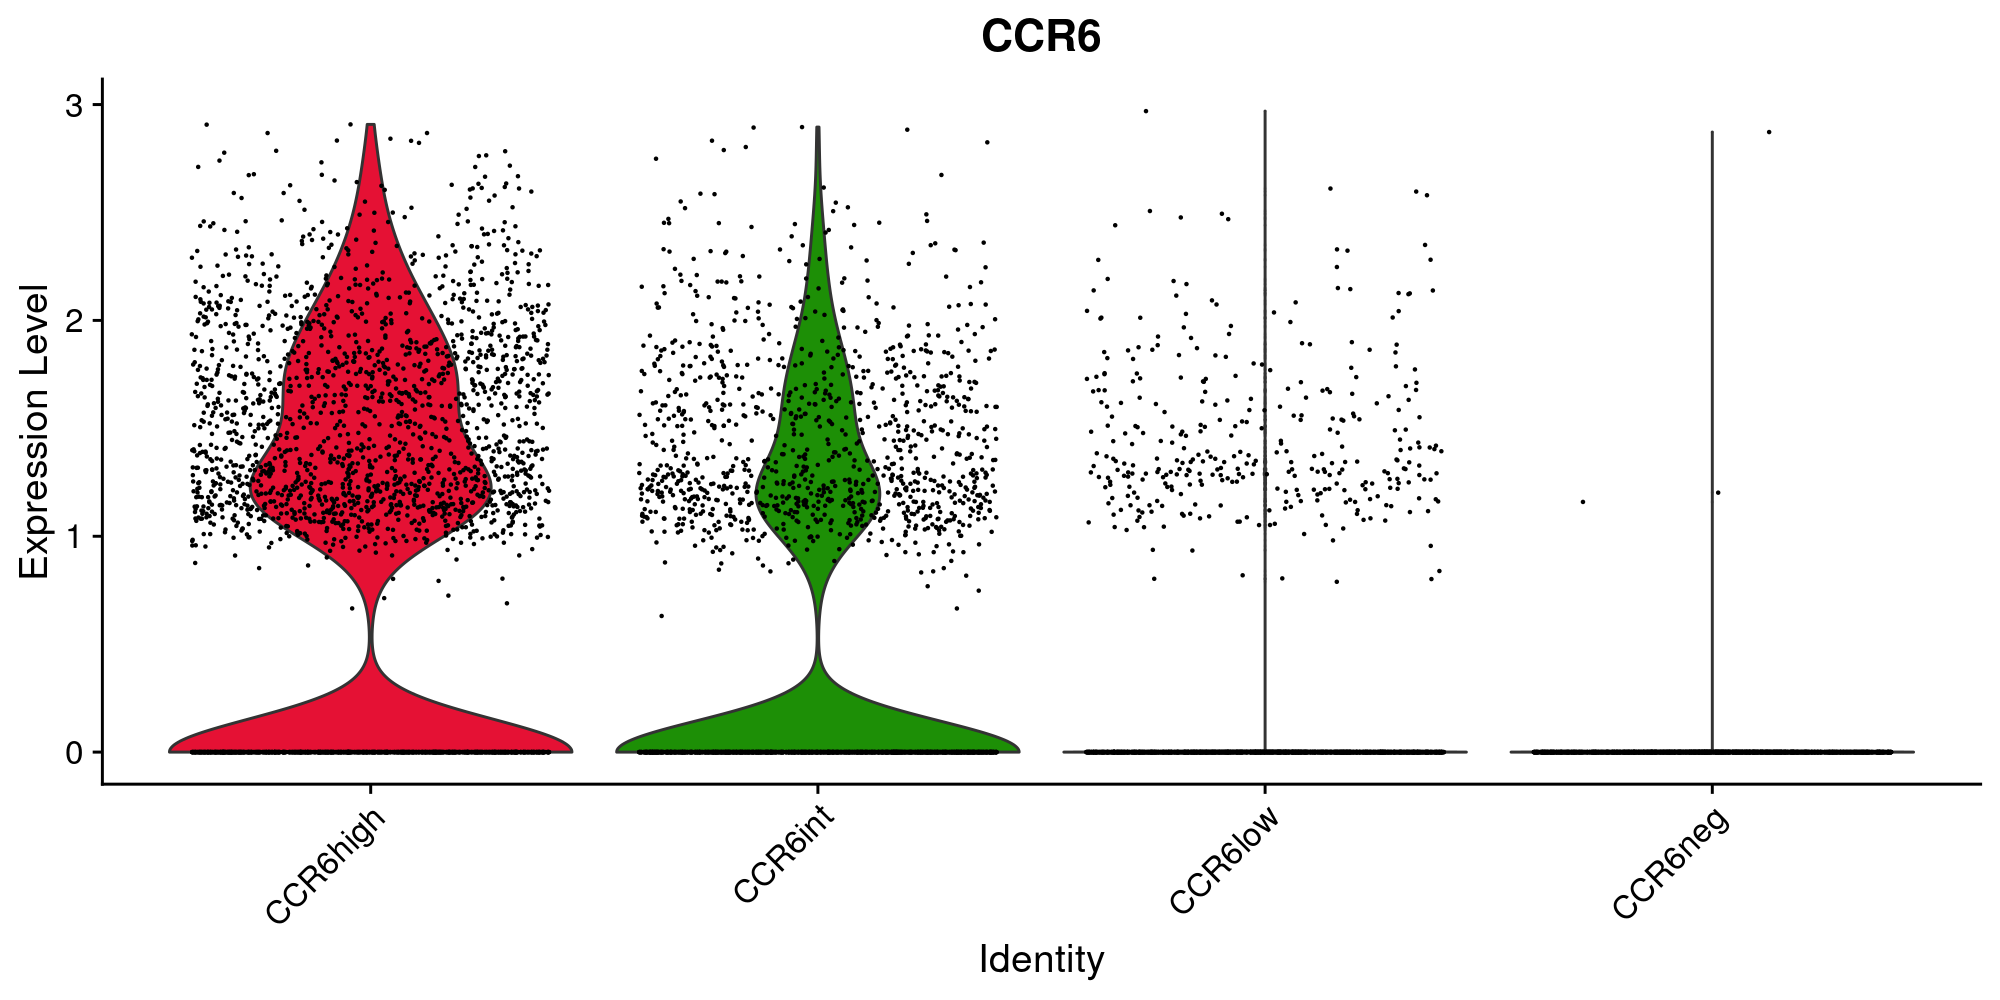

In [62]:
options(repr.plot.width=10, repr.plot.height=5, repr.plot.res = 200)
VlnPlot(alldata, group.by= "orig.ident", features = "CCR6", pt.size =0.1, ncol = 1, use.raw=T,
        cols=GroupID_Color_List) + 
NoLegend()# +
#geom_boxplot(width=0.1,fill="white")

In [63]:
saveRDS(alldata,"./Result/CCR6_Project_01_Normalization.rds")